# Intuitional Description

The Bayes factor is the ratio of two **marginal** likelihoods; that is, the likelihoods of two statistical models integrated over the prior probabilities of their parameters.


# Graphical Summary

![fig](./cartoons/Bayes_factor.svg)

# Key Formula

Given a model selection problem in which one wishes to choose between two models on the basis of observed data $\text{D}$, the plausibility of the two different models $\text{M}_1$ and $\text{M}_2$, parametrised by model parameter vectors $\gamma_1$ and $\gamma_2$, is assessed by the Bayes factor $\text{BF}$ given by:
$$
\text{BF}_{1,2} = \frac{L(\text{D}|\text{M}_1)}{L(\text{D}|\text{M}_2)} ={\frac {\int \Pr(\gamma _{1}|M_{1})\Pr(D|\gamma _{1},M_{1})\,d\gamma _{1}}{\int \Pr(\gamma _{2}|M_{2})\Pr(D|\gamma _{2},M_{2})\,d\gamma _{2}}}
$$

# Technical Details

- If instead of the Bayes factor integral, the likelihood corresponding to the maximum likelihood estimate (MLE) of the parameter for each statistical model is used, then the test becomes a classical likelihood-ratio test. The likelihood at the MLE is just a point estimate of the Bayes factor numerator and denominator, respectively. 
- Unlike a likelihood-ratio test (LRT), this Bayesian model comparison **does not depend on any single set of parameters, as it integrates over all parameters in each model (with respect to the respective priors)**. 
- Therefore, **likelihood ratio** can be considered as a **special case of Bayesian analysis** with a contrived prior that's hard to get at. 
- An advantage of the use of Bayes factors is that it automatically, and quite naturally, includes a penalty for including too much model structure. It thus guards against overfitting. For models where an explicit version of the likelihood is not available or too costly to evaluate numerically, approximate Bayesian computation can be used for model selection in a Bayesian framework, with the caveat that approximate-Bayesian estimates of Bayes factors are often biased.

# Example

In this example we compare two pairs of model:
- Model 1 and Model 2, both under fixed effect
- Model 4 and Model 5, both under random effect

In [2]:
# Clear the environment
rm(list = ls())

# Define genotypes for 5 individuals at 3 variants
# These represent actual alleles at each position
# For example, Individual 1 has genotypes: CC, CT, AT
genotypes <- c(
    "CC", "CT", "AT", # Individual 1
    "TT", "TT", "AA", # Individual 2
    "CT", "CT", "AA", # Individual 3
    "CC", "TT", "AA", # Individual 4
    "CC", "CC", "TT" # Individual 5
)
# Reshape into a matrix
N <- 5 # number of individuals
M <- 3 # number of variants
geno_matrix <- matrix(genotypes, nrow = N, ncol = M, byrow = TRUE)
rownames(geno_matrix) <- paste("Individual", 1:N)
colnames(geno_matrix) <- paste("Variant", 1:M)

alt_alleles <- c("T", "C", "T")
ref_alleles <- c("C", "T", "A")

# Convert to raw genotype matrix using the additive / dominant / recessive model
Xraw_additive <- matrix(0, nrow = N, ncol = M) # dount number of non-reference alleles

rownames(Xraw_additive) <- rownames(geno_matrix)
colnames(Xraw_additive) <- colnames(geno_matrix)

for (i in 1:N) {
    for (j in 1:M) {
        alleles <- strsplit(geno_matrix[i, j], "")[[1]]
        Xraw_additive[i, j] <- sum(alleles == alt_alleles[j])
    }
}
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)

# assign observed height for the 5 individuals
Y_raw <- c(180, 160, 158, 155, 193)
Y <- scale(Y_raw)

## Fixed effect model

Let's first compare two competing models with fixed effect sizes (same models as we discussed in `likelihood` and `likelihood_ratio`):

- **Model 1 ($M_1$)**: The variant has no effect on height ($\beta=0$)
- **Model 2 ($M_2$)**: The variant has moderate effect on height ($\beta=0.5$)

For both models, we assume:
- $\mathbf{Y} = \mathbf{X}\beta + \epsilon$, where $\epsilon \sim N(0, \sigma^2)$
- $\sigma^2$ is the residual variance (fixed at 1 for standardized data)


The Bayes Factor ($K_{1,2}$) (comparing model 1 and model 2) is the ratio of the marginal likelihoods of the two models:

$$BF_{1,2} = \frac{p(Y|M_1)}{p(Y|M_2)}$$

For models with **fixed effect sizes**, the marginal likelihood is simply the likelihood function evaluated at the fixed parameter value:

$$
p(Y|M_1) = p(Y|\beta=0, M_1)\\
p(Y|M_2) = p(Y|\beta=1, M_2)
$$

In [23]:
# Function to calculate the likelihood for a fixed effect model
# assuming normal distribution for residuals
likelihood <- function(beta, sd, X, Y) {
    # beta: effect size parameter
    # sd: standard deviation of residuals
    # X: genotype values
    # Y: observed phenotype values

    # Calculate expected values under the model
    mu <- X * beta

    # Calculate likelihood (product of normal densities)
    prod(dnorm(Y, mean = mu, sd = sd, log = FALSE))
}

# Function to calculate Bayes Factor between two fixed effect models
bayes_factor <- function(X, Y, beta1, beta2, sigma = 1) {
    # Calculate likelihoods
    likelihood_M1 <- likelihood(beta1, sigma, X, Y)
    likelihood_M2 <- likelihood(beta2, sigma, X, Y)
    
    # Calculate Bayes Factor (M1 vs M2)
    BF12 <- likelihood_M1 / likelihood_M2
    return(BF12)
}


In [24]:
# Initialize results table
bf_table <- data.frame(
    Variant = paste("Variant", 1:M),
    Likelihood_M1 = numeric(M), # Likelihood for Model 1 (β=0)
    Likelihood_M2 = numeric(M), # Likelihood for Model 3 (β=1)
    BF12 = numeric(M), # Bayes Factor (M3 vs M1)
    log_BF12 = numeric(M) # Log of Bayes Factor
)

# Set parameters for models
sigma <- 1 # Standard deviation of residuals
beta1 <- 0 # Effect size for Model 1
beta2 <- 0.5 # Effect size for Model 2

# Calculate Bayes Factors for each variant
for (j in 1:M) {
    X_j <- X[, j] # Genotypes for variant j

    # Calculate likelihoods
    bf_table[j, "Likelihood_M1"] <- likelihood(beta1, sigma, X_j, Y)
    bf_table[j, "Likelihood_M2"] <- likelihood(beta2, sigma, X_j, Y)

    # Calculate Bayes Factor
    bf_table[j, "BF12"] <- bf_table[j, "Likelihood_M1"] / bf_table[j, "Likelihood_M2"]
    bf_table[j, "log_BF12"] <- log(bf_table[j, "BF12"])
}
bf_table

Variant,Likelihood_M1,Likelihood_M2,BF12,log_BF12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Variant 1,0.001367607,0.0003050987,4.4825078,1.500183
Variant 2,0.001367607,0.0045633971,0.2996906,-1.205005
Variant 3,0.001367607,0.0059679052,0.2291603,-1.473333


Note that under the two full specific models, the Bayes factor is exactly the likelihood ratio that we get from `likelihood ratio` notebook [FIXME with link].

## Random effect model

Now let's compare two competing models with random effect sizes:

- **Model 4 ($M_4$)**: The effect size follows a normal distribution with smaller variance ($\beta \sim N(0, 0.1^2)$)
- **Model 5 ($M_5$)**: The effect size follows a normal distribution with larger variance ($\beta \sim N(0, 0.5^2)$)

For both models, we assume:
- $\mathbf{Y} = \mathbf{X}\beta + \epsilon$, where $\epsilon \sim N(0, \sigma^2)$
- $\beta$ is the random effect of the genetic variant on height
- $\mathbf{X}$ is the genotype data (standardized)
- $\mathbf{Y}$ is the observed phenotype (standardized height)
- $\sigma^2$ is the residual variance (fixed at 1 for standardized data)

The key difference between these models is the prior distribution of the effect size:
- Model 4 assumes a tighter prior distribution, strongly favoring small effect sizes
- Model 5 assumes a more diffuse prior distribution, allowing for larger effect sizes


With normal priors and normal likelihood, this integration has a closed-form solution, which we've implemented in the `random_effect_marginal_likelihood` function:

For a linear model $\mathbf{Y} = \mathbf{X}\beta + \varepsilon$ with:
- $\mathbf{Y}$ as an $n \times 1$ vector of standardized heights
- $\mathbf{X}$ as an $n \times 1$ vector of standardized genotypes
- $\beta \sim N(0, \tau^2)$ as the random effect
- $\varepsilon \sim N(0, \sigma^2\mathbf{I})$ as the residual errors

The marginal likelihood $p(\mathbf{Y}|\mathbf{X},\tau^2,\sigma^2)$ is:

$$
p(\mathbf{Y}|\mathbf{X},\tau^2,\sigma^2) = \int p(\mathbf{Y}|\mathbf{X},\beta,\sigma^2)p(\beta|\tau^2)d\beta
$$

$$
p(\mathbf{Y}|\mathbf{X},\tau^2,\sigma^2) = \frac{1}{(2\pi)^{n/2}|\sigma^2\mathbf{I}+\tau^2\mathbf{XX'}|^{1/2}}\exp\left(-\frac{1}{2}\mathbf{Y}'(\sigma^2\mathbf{I}+\tau^2\mathbf{XX'})^{-1}\mathbf{Y}\right)
$$

Using the matrix inversion lemma and simplifying:

$$
p(\mathbf{Y}|\mathbf{X},\tau^2,\sigma^2) = \frac{1}{(2\pi\sigma^2)^{n/2}(1+\tau^2\mathbf{X}'\mathbf{X}/\sigma^2)^{1/2}}\exp\left(-\frac{1}{2\sigma^2}\left(\mathbf{Y}'\mathbf{Y}-\frac{\tau^2(\mathbf{X}'\mathbf{Y})^2}{\sigma^2+\tau^2\mathbf{X}'\mathbf{X}}\right)\right)
$$

In [3]:
random_effect_marginal_likelihood <- function(X, Y, prior_var, residual_var = 1) {
  # For random effect models, the marginal likelihood has a closed form
  # when using normal priors and normal likelihood
  n <- length(Y)
  
  # Calculate posterior variance
  post_var <- 1 / (1/prior_var + sum(X^2)/residual_var)
  
  # Calculate posterior mean
  post_mean <- post_var * sum(X * Y) / residual_var
  
  # Calculate marginal likelihood
  log_ml <- -n/2 * log(2 * pi * residual_var) - 
            1/2 * log(1 + prior_var * sum(X^2) / residual_var) -
            1/(2 * residual_var) * (sum(Y^2) - post_mean^2/post_var)
  
  return(exp(log_ml))
}

# Function to calculate Bayes Factor between two random effect models
bayes_factor_random <- function(X, Y, prior_var1, prior_var2, residual_var = 1) {
  # Calculate marginal likelihoods
  ml_model4 <- random_effect_marginal_likelihood(X, Y, prior_var1, residual_var)
  ml_model5 <- random_effect_marginal_likelihood(X, Y, prior_var2, residual_var)
  
  # Calculate Bayes Factor (Model 4 vs Model 5)
  BF45 <- ml_model4 / ml_model5
  
  return(BF45)
}

In [5]:
# Define model parameters
prior_var_model4 <- 0.1^2  # Smaller variance for Model 4
prior_var_model5 <- 0.5^2  # Larger variance for Model 5
residual_var <- 1          # Residual variance (fixed)

# Initialize results table
bf_random_table <- data.frame(
  Variant = paste("Variant", 1:M),
  ML_Model4 = numeric(M),    # Marginal likelihood for Model 4
  ML_Model5 = numeric(M),    # Marginal likelihood for Model 5
  BF45 = numeric(M),         # Bayes Factor (Model 4 vs Model 5)
  log_BF45 = numeric(M)      # Log of Bayes Factor
)

# Calculate Bayes Factors for each variant
for (j in 1:M) {
  X_j <- X[, j]  # Genotypes for variant j
  
  # Calculate marginal likelihoods
  bf_random_table[j, "ML_Model4"] <- random_effect_marginal_likelihood(
    X_j, Y, prior_var_model4, residual_var
  )
  bf_random_table[j, "ML_Model5"] <- random_effect_marginal_likelihood(
    X_j, Y, prior_var_model5, residual_var
  )
  
  # Calculate Bayes Factor
  bf_random_table[j, "BF45"] <- bf_random_table[j, "ML_Model4"] / 
                               bf_random_table[j, "ML_Model5"]
  bf_random_table[j, "log_BF45"] <- log(bf_random_table[j, "BF45"])
}
bf_random_table

Variant,ML_Model4,ML_Model5,BF45,log_BF45
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Variant 1,0.001367098,0.001241823,1.1008798,0.09610969
Variant 2,0.001418155,0.002000204,0.7090052,-0.34389240
Variant 3,0.001445330,0.002559982,0.5645861,-0.57166244


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


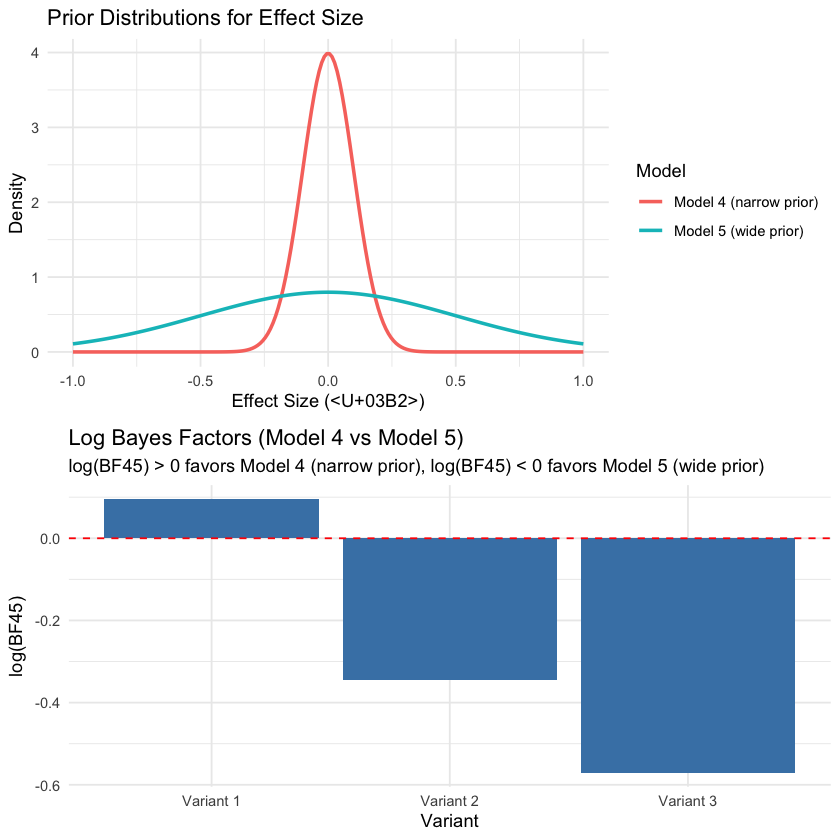

In [6]:
# Load required libraries
library(ggplot2)
library(gridExtra)

# Plot the prior distributions for effect sizes in both models
beta_range <- seq(-1, 1, length.out = 200)
prior_model4 <- dnorm(beta_range, mean = 0, sd = sqrt(prior_var_model4))
prior_model5 <- dnorm(beta_range, mean = 0, sd = sqrt(prior_var_model5))

prior_data <- data.frame(
  Beta = rep(beta_range, 2),
  Density = c(prior_model4, prior_model5),
  Model = rep(c("Model 4 (narrow prior)", "Model 5 (wide prior)"), each = length(beta_range))
)

prior_plot <- ggplot(prior_data, aes(x = Beta, y = Density, color = Model)) +
  geom_line(size = 1) +
  labs(title = "Prior Distributions for Effect Size",
       x = "Effect Size (β)",
       y = "Density") +
  theme_minimal()

# Plot log Bayes factors
bf_plot <- ggplot(bf_random_table, aes(x = Variant, y = log_BF45)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Log Bayes Factors (Model 4 vs Model 5)",
       subtitle = "log(BF45) > 0 favors Model 4 (narrow prior), log(BF45) < 0 favors Model 5 (wide prior)",
       y = "log(BF45)") +
  theme_minimal()

# Arrange plots
grid.arrange(prior_plot, bf_plot, ncol = 1)

Random effect models offer a more flexible approach than fixed effect models by allowing the effect size to vary according to a probability distribution. This is particularly useful when:

1. We are uncertain about the exact effect size
2. We believe effects may vary across different contexts or populations
3. We want to account for heterogeneity in genetic effects

The Bayes factor between two random effect models ($\text{BF}_{45}$) quantifies the relative evidence for different prior distributions on the effect size. A $\text{BF}_{45} > 1$ indicates that Model 4 (with narrower prior) is more supported by the data, while $\text{BF}_{45} < 1$ favors Model 5 (with wider prior).

When comparing fixed and random effect models, we're essentially testing whether the data supports a specific effect size or a distribution of possible effect sizes. These comparisons can help identify the most appropriate modeling approach for genetic association studies.

The key formula for the Bayes factor between two random effect models is:

$$
\text{BF}_{45} = \frac{p(D|M_4)}{p(D|M_5)} = \frac{\int p(D|\beta,M_4)p(\beta|M_4)d\beta}{\int p(D|\beta,M_5)p(\beta|M_5)d\beta}
$$

This approach provides a principled way to incorporate prior knowledge about effect sizes while allowing for uncertainty in genetic association studies.